In [16]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%autoreload 2

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
from pylab import plot, show, savefig
from scipy import stats
#%pylab inline

In [19]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-10-21/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
files_start = 2186
files_end = 2326


In [31]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["112", "114", "115", "116", "117", "119", "120", "122", "124"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "118"
isotope_column = ["112", "114", "115", "116", "117", "119", "120", "122", "124"]
data_sample_column = [(i + "/" + "118") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['112/118', '114/118', '115/118', '116/118', '117/118', '119/118', '120/118', '122/118', '124/118']


In [32]:
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
columns_2 = ["cycle", "H8 (2)", "H7 (2)", "H6 (2)", "H5 (2)", "H4 (2)", "H3 (2)", "H2 (2)", "H1 (2)", "Ax (2)", "L1 (2)", "L2 (2)", "L3 (2)", "L4 (2)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
for sample in files_1:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    df_zero = df.data_zero_corr(sample)
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    df_zero_2 = pd.DataFrame(df_zero["cycle2"])
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    df_zero_2["cycle"] = df_zero_2.index.values
    df_zero_1.index = df_zero_1["date"]
    df_zero_1 = df_zero_1[columns_1]
    df_zero_2 = df_zero_2[columns_2]
    df_all = df_all.append(df_zero_1.merge(df_zero_2), ignore_index = True)
    #df_all = df_all.append(df_zero_1, ignore_index = True)
    
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "teflon blank":
        None
    else:
        sample_ls.append(sample)

df_all.set_index("date", inplace = True)
df_all
#for x in [123]:
#    sample_ls.remove(x)
#blk_ls

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),...,H5 (2),H4 (2),H3 (2),H2 (2),H1 (2),Ax (2),L1 (2),L2 (2),L3 (2),L4 (2)
date,,,,,,,,,,,,,,,,,,,,,
2015-10-21 18:36:00,1,blank sol,0.000560,0.000395,0.003276,0.000719,0.002019,0.000636,0.001190,0.000071,...,0.000039,3.664500e-06,0.000628,0.000206,0.000501,0.000229,0.003832,0.000873,0.002383,0.000780
2015-10-21 18:36:00,2,blank sol,0.000537,0.000392,0.003017,0.000691,0.001818,0.000589,0.001115,0.000049,...,0.000069,2.509510e-05,0.000554,0.000252,0.000402,0.000284,0.003394,0.000740,0.002092,0.000691
2015-10-21 18:36:00,3,blank sol,0.000505,0.000367,0.002880,0.000612,0.001704,0.000550,0.001024,0.000095,...,0.000045,-2.580800e-06,0.000370,0.000171,0.000282,0.000227,0.002299,0.000445,0.001272,0.000421
2015-10-21 18:36:00,4,blank sol,0.000431,0.000297,0.002607,0.000481,0.001524,0.000488,0.000887,0.000046,...,0.000051,1.170700e-05,0.000401,0.000208,0.000288,0.000238,0.002590,0.000539,0.001539,0.000474
2015-10-21 18:36:00,5,blank sol,0.000498,0.000327,0.002802,0.000573,0.001689,0.000563,0.001011,0.000054,...,0.000053,-7.950000e-07,0.000533,0.000161,0.000392,0.000244,0.003354,0.000729,0.002006,0.000641
2015-10-21 18:36:00,6,blank sol,0.000519,0.000371,0.002973,0.000617,0.001741,0.000595,0.001049,0.000044,...,0.000041,6.346800e-06,0.000632,0.000173,0.000454,0.000262,0.003483,0.000790,0.002154,0.000665
2015-10-21 18:36:00,7,blank sol,0.000524,0.000373,0.002977,0.000641,0.001784,0.000570,0.001070,0.000065,...,0.000057,2.598850e-05,0.000352,0.000170,0.000270,0.000205,0.002338,0.000501,0.001343,0.000408
2015-10-21 18:36:00,8,blank sol,0.000623,0.000452,0.003516,0.000796,0.002148,0.000707,0.001299,0.000085,...,0.000080,2.062640e-05,0.000448,0.000215,0.000272,0.000207,0.002462,0.000484,0.001410,0.000491
2015-10-21 18:36:00,9,blank sol,0.000452,0.000328,0.002760,0.000594,0.001589,0.000518,0.000988,0.000032,...,0.000047,2.420570e-05,0.000366,0.000147,0.000258,0.000200,0.002253,0.000472,0.001207,0.000389


In [34]:
files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_internal_norm = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    # arbitrary blank positions
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    if (blk_corr == True) and (blk_corr_sample == True):
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    else:
        df_zero = df.data_zero_corr(sample)
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
        new_corr.line2_corr(df_zero, "119")
    
    data_sample_raw = new_corr.raw_signals(denom_isotope)
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = data_sample_raw[np.abs(data_sample_raw-data_sample_raw.mean())<=(2*data_sample_raw.std())]
    
    data_sample = new_corr.internal_norm_1(denom_isotope, 10)
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    data_sample = data_sample[np.abs(data_sample-data_sample.mean())<=(2*data_sample.std())]
    
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_sample = data_sample.drop(denom_isotope, axis=1)
    data_sample = data_sample[sorted(data_sample.columns)]
    data_sample.columns = data_sample_column
    data_sample["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_sample["sample"] = sample_name
    data_sample["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_sample = data_sample.merge(data_sample_raw)
    
    df_internal_norm = df_internal_norm.append(data_sample)
    print sample

2187
2188
2189
2190
2191
2193
2194
2195
2196
2197
2199
2200
2201
2202
2203
2205
2206
2207
2208
2209
2211
2212
2213
2214
2215
2217
2218
2219
2220
2221
2223
2224
2225
2226
2227
2229
2230
2231
2232
2233
2235
2236
2237
2238
2239
2241
2242
2243
2245
2246
2247
2248
2249
2251
2252
2253
2254
2255
2257
2258
2259
2260
2262
2263
2264
2265
2266
2268
2269
2270
2271
2272
2274
2275
2276
2277
2278
2280
2281
2282
2283
2284
2286
2287
2288
2289
2290
2292
2293
2294
2295
2296
2298
2299
2300
2301
2302
2304
2305
2306
2308


ValueError: math domain error

In [24]:
df_internal_norm= df_internal_norm.set_index("date")
columns = ["cycle", "sample"]
columns.extend(data_sample_column)
columns.extend(sorted(data_sample_raw.drop("cycle", axis=1).columns))
df_internal_sub = pd.DataFrame(df_internal_norm, columns = columns)

df_all_sub = df_all[(df_all["sample"] != "blank sol") & (df_all["sample"] != "SQ")]
df_internal_sub["111"] = df_all_sub["L3 (1)"]
df_internal_sub["125"] = df_all_sub["H5 (2)"]
df_internal_sub["Cd/Sn"] = (df_all_sub["L3 (1)"]/12.722)/(df_all_sub["H4 (1)"]/24.223)
df_internal_sub["Te/Sn"] = (df_all_sub["H5 (2)"]/7.0509)/(df_all_sub["H4 (1)"]/24.223)
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")

In [25]:
def SE(x):
    SE = np.std(x) / x.count()
    return SE

df_internal_norm_mean = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).mean()
df_internal_norm_mean_sd = df_internal_sub.drop("cycle", axis=1).groupby(df_internal_sub.index).agg([np.mean, SE])
df_internal_norm_mean["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
df_internal_norm_mean_sd["sample"] = df_internal_norm[df_internal_norm["cycle"] == 1]["sample"]
#df_internal_norm_mean = df_internal_norm_mean[1:]
#df_internal_norm_mean = df_internal_norm_mean.drop(datetime.strptime("20150310 23:59", "%Y%m%d %H:%M"))
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:]
df_internal_norm_mean
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,112,...,118,119,120,122,124,111,125,Cd/Sn,Te/Sn,sample
date,,,,,,,,,,,,,,,,,,,,,
2015-10-21 18:45:00,0.040138,0.027164,0.013951,0.600332,0.316723,0.354621,1.346100,0.19125,0.238993,0.215607,...,5.827759,2.094312,8.055034,1.174648,1.505974,0.000066,0.000030,0.000022,0.000018,NIST 100ppb
2015-10-21 18:58:00,0.040131,0.027160,0.013953,0.600326,0.316718,0.354613,1.346097,0.19125,0.238994,0.215353,...,5.821601,2.092099,8.046809,1.173467,1.504526,0.000081,0.000050,0.000027,0.000029,NIST 100ppb
2015-10-21 19:10:00,0.040143,0.027173,0.013951,0.600321,0.316725,0.354618,1.346106,0.19125,0.238996,0.211656,...,5.720484,2.055732,7.906710,1.152983,1.478175,0.000050,0.000041,0.000017,0.000027,NIST 100ppb
2015-10-21 19:22:00,0.040134,0.027160,0.013950,0.600326,0.316725,0.354615,1.346102,0.19125,0.238979,0.215997,...,5.837137,2.097591,8.067513,1.176385,1.508047,0.000078,0.000043,0.000025,0.000025,NIST 100ppb
2015-10-21 19:34:00,0.040142,0.027173,0.013952,0.600324,0.316718,0.354616,1.346094,0.19125,0.238988,0.203850,...,5.506022,1.978468,7.608670,1.109326,1.421915,0.000056,0.000056,0.000020,0.000038,NIST 100ppb
2015-10-21 19:56:00,0.040141,0.027164,0.013952,0.600321,0.316724,0.354607,1.346092,0.19125,0.238990,0.180950,...,4.888662,1.756658,6.756175,0.985117,1.262822,0.000056,0.000041,0.000022,0.000033,NIST 100ppb
2015-10-21 20:08:00,0.040137,0.027164,0.013951,0.600324,0.316721,0.354610,1.346091,0.19125,0.238992,0.208402,...,5.630480,2.023236,7.781272,1.134568,1.454392,0.000068,0.000049,0.000023,0.000030,NIST 100ppb
2015-10-21 20:25:00,0.040138,0.027161,0.013954,0.600323,0.316730,0.354619,1.346108,0.19125,0.238991,0.214029,...,5.778391,2.076197,7.984111,1.163900,1.491689,0.000077,0.000067,0.000026,0.000040,NIST 100ppb
2015-10-21 20:37:00,0.040142,0.027167,0.013951,0.600332,0.316724,0.354612,1.346115,0.19125,0.238993,0.203265,...,5.488887,1.972190,7.584498,1.105711,1.417195,0.000055,0.000039,0.000021,0.000024,NIST 100ppb


In [26]:
#plot_Nist = df_internal_norm_mean[df_internal_norm_mean["sample"] == "NIST 100ppb"]
plot_Nist = df_internal_norm_mean[(df_internal_norm_mean["118"] >= .5)]
#dataplot = plot(plot_Nist["Te/Sn"], plot_Nist["124/120"], "ro")
dataplot = plot(plot_Nist.index, plot_Nist["120"], "ro")
show(dataplot)

In [27]:
sub_index = df_internal_norm_mean[(df_internal_norm_mean["sample"].shift(1) == df_internal_norm_mean["sample"].shift(-1)) & (df_internal_norm_mean["sample"].shift(1) == "NIST 100ppb")].index
#corr_values = df_internal_norm_mean[(df_external_norm_mean >= 0.74289)]
#corr_values = df_internal_norm_mean[:"20150110 10:00"]
corr_values = df_internal_norm_mean[df_internal_norm_mean["118"] >= 1]
#corr_values = df_internal_norm_mean
sample = corr_values["sample"]
std_mean = corr_values[(corr_values["sample"] == "NIST 100ppb")].mean()
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]

#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample
epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*10000
epsilon_2 = ((new / ((new.shift(2) + new.shift(-2))/2))-1)*10000
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample

epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#new[new.sample != "NIST 100ppb"]
epsilon_2 = epsilon_2[epsilon_2["sample"] == "NIST 100ppb"]
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=True)
epsilon_comp

,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,112,...,118,119,120,122,124,111,125,Cd/Sn,Te/Sn,sample
0,-2.492015,-3.133497,1.307386,-0.020877,-0.184074,-0.188370,-0.044192,2.220446e-12,-0.048348,80.583460,...,82.227630,82.294937,82.618810,82.926961,83.452911,4048.568337,4044.562867,3699.819066,3048.125777,NIST 100ppb
1,2.734280,4.800309,-0.233302,-0.071745,0.109359,0.124453,0.050607,0.000000e+00,0.411412,-186.352277,...,-186.786401,-186.708359,-186.729505,-186.757421,-186.629400,-3690.623804,-1163.992680,-3308.525667,-0.730170,NIST 100ppb
2,-2.130728,-4.721477,-1.267874,0.049427,0.107357,-0.065786,0.015862,0.000000e+00,-0.541509,396.810354,...,398.848525,399.043013,399.374944,399.859252,400.001971,4646.424676,-1120.105540,3656.887255,-2230.436915,NIST 100ppb
3,1.036356,3.808091,0.956551,0.017363,-0.195152,0.131769,-0.023959,0.000000e+00,0.149694,270.906528,...,266.875494,266.423334,265.556405,264.399928,263.315627,-1625.488897,3217.021736,-1649.868192,3013.498035,NIST 100ppb
4,0.497707,-1.409890,0.436445,-0.061188,0.125467,-0.152222,-0.004914,0.000000e+00,-0.012402,-1221.413140,...,-1220.471344,-1220.448154,-1220.012234,-1219.573127,-1219.142979,-1006.527346,-2127.777718,231.825016,-382.281397,NIST 100ppb
5,-0.702927,0.367120,-1.616073,0.045649,-0.169533,-0.089643,-0.066469,0.000000e+00,0.077881,552.584454,...,556.767745,557.329286,557.829853,558.943423,560.072283,197.249952,-934.539072,-300.325408,-1707.941161,NIST 100ppb
6,-0.381349,-1.455814,1.970317,-0.095832,0.225491,0.221538,0.038242,0.000000e+00,-0.072949,398.166764,...,393.381544,392.871234,392.074924,390.676035,389.299480,2587.127862,5333.184241,1763.339131,4743.735468,NIST 100ppb
7,1.290983,1.921676,-0.569024,0.274311,-0.006511,-0.206526,-0.007481,2.220446e-12,-0.224455,-358.953314,...,-357.777533,-357.791105,-357.445197,-356.993088,-356.753343,-2397.744961,-3789.456480,-1712.159667,-3647.467924,NIST 100ppb
8,-1.261102,-1.887685,-1.597763,-0.246435,-0.095923,0.247130,0.103109,-1.110223e-12,0.469950,-112.510099,...,-115.184392,-115.419447,-115.955078,-116.887880,-117.499401,1734.518799,2920.998214,1860.953426,3561.331816,NIST 100ppb
9,0.770430,1.430450,0.282349,0.175943,0.019909,0.097321,-0.034452,-1.110223e-12,-0.439017,-60.335010,...,-64.893655,-64.823309,-65.003440,-61.974967,-60.984634,-861.042917,490532.840195,-827.024258,492667.661908,NIST 100ppb + Te 0.2ppb


In [28]:
def SD2(x):
    SD2 = np.std(x) * 2
    return SD2

epsilon = epsilon_comp.drop(["111", "125", "112", "114", "115", "116", "117", "118", "119", "120", "122", "124", "Cd/Sn", "Te/Sn"], axis = 1)
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2]), decimals=2)
epsilon_sum

112/118       114/118       115/118       116/118  \
                            mean   SD2    mean   SD2    mean   SD2    mean   
sample                                                                       
NIST 100ppb                -0.02  1.82   -0.16  3.41   -0.09  2.88   -0.00   
NIST 100ppb + Cd 0.03ppb    0.80  0.96    1.61  1.15    0.31  2.41    0.08   
NIST 100ppb + Cd 0.05ppb   -0.04  0.22    2.52  0.37    0.32  4.38    0.10   
NIST 100ppb + Cd 0.07ppb    0.23  2.47    2.74  2.47    0.86  1.04    0.18   
NIST 100ppb + Cd 0.15ppb    2.74  0.05    7.91  0.24    0.56  2.67    0.26   
NIST 100ppb + Cd 0.1ppb     0.02  1.74    3.96  1.99    1.55  1.39    0.18   
NIST 100ppb + Te 0.2ppb     0.10  2.22   -0.31  4.39   -0.16  1.65    0.01   
NIST 100ppb + Te 0.5ppb     0.87  0.43    0.16  1.27   -0.96  3.07   -0.05   
NIST 100ppb + Te 1ppb      -0.19  0.22    1.01  2.83    0.02  1.41    0.12   
NIST 100ppb + Te 2ppb       0.11  0.91   -0.54  2.03   -0.06  1.36   -0.15   
NIST 100ppb + Te 4ppb       0.42  2.06    0.75  2.37   -0.36  1.35    0.04   
NIST 100ppb + Te 8ppb      -0.55  1.19   -1.23  1.54    0.20  0.97   -0.10   
NIST 100ppb + U 0.003ppb    0.09  2.07   -0.36  0.68   -0.57  0.38   -0.04   
NIST 100ppb + U 0.005ppb    0.11  1.56   -1.15  1.63   -0.49  0.31    0.01   
NIST 100ppb + U 0.01ppb    -1.97  0.27   -2.78  0.47    6.39  0.90   -0.34   
NIST 100ppb + U 0.03ppb     0.72  0.77    1.30  2.92   -0.79  2.62   -0.06   

                               117/118       119/118       120/118        \
                           SD2    mean   SD2    mean   SD2    mean   SD2   
sample                                                                     
NIST 100ppb               0.32   -0.00  0.30   -0.03  0.22   -0.00  0.15   
NIST 100ppb + Cd 0.03ppb  0.10    0.10  0.19   -0.01  0.19   -0.05  0.09   
NIST 100ppb + Cd 0.05ppb  0.10    0.03  0.41    0.14  0.03    0.00  0.09   
NIST 100ppb + Cd 0.07ppb  0.08    0.09  0.13    0.05  0.12   -0.08  0.10   
NIST 100ppb + Cd 0.15ppb  0.22    0.14  0.19    0.06  0.06   -0.04  0.14   
NIST 100ppb + Cd 0.1ppb   0.06    0.10  0.05    0.03  0.11   -0.03  0.22   
NIST 100ppb + Te 0.2ppb   0.23   -0.06  0.11    0.07  0.04    0.03  0.09   
NIST 100ppb + Te 0.5ppb   0.30   -0.04  0.05    0.04  0.07    0.02  0.25   
NIST 100ppb + Te 1ppb     0.05   -0.14  0.08   -0.00  0.02   -0.07  0.13   
NIST 100ppb + Te 2ppb     0.41   -0.05  0.27    0.11  0.03    0.07  0.05   
NIST 100ppb + Te 4ppb     0.02    0.02  0.03    0.11  0.11    0.00  0.16   
NIST 100ppb + Te 8ppb     0.20    0.05  0.21    0.27  0.03    0.14  0.08   
NIST 100ppb + U 0.003ppb  0.25   -0.01  0.13    0.20  0.24   -0.03  0.13   
NIST 100ppb + U 0.005ppb  0.16   -0.11  0.09    0.25  0.02    0.04  0.04   
NIST 100ppb + U 0.01ppb   0.10   -0.31  0.13   -0.05  0.24    0.02  0.08   
NIST 100ppb + U 0.03ppb   0.32   -0.09  0.19    0.89  0.07    0.01  0.11   

                         122/118     124/118        
                            mean SD2    mean   SD2  
sample                                              
NIST 100ppb                    0   0   -0.00  0.51  
NIST 100ppb + Cd 0.03ppb       0   0   -0.08  0.12  
NIST 100ppb + Cd 0.05ppb       0   0    0.02  0.36  
NIST 100ppb + Cd 0.07ppb      -0   0   -0.09  0.63  
NIST 100ppb + Cd 0.15ppb      -0   0   -0.16  0.04  
NIST 100ppb + Cd 0.1ppb        0   0    0.02  0.19  
NIST 100ppb + Te 0.2ppb        0   0   -0.10  0.50  
NIST 100ppb + Te 0.5ppb        0   0   -0.04  0.73  
NIST 100ppb + Te 1ppb          0   0   -0.07  0.17  
NIST 100ppb + Te 2ppb         -0   0    0.25  0.20  
NIST 100ppb + Te 4ppb         -0   0   -0.02  0.24  
NIST 100ppb + Te 8ppb          0   0    0.45  0.12  
NIST 100ppb + U 0.003ppb       0   0    0.02  0.32  
NIST 100ppb + U 0.005ppb       0   0    0.01  0.25  
NIST 100ppb + U 0.01ppb        0   0    0.26  0.01  
NIST 100ppb + U 0.03ppb        0   0    0.04  0.30

In [29]:
x = range(1, len(epsilon_sum.index)+1)
errorbar(epsilon_sum["112/118"]["mean"], x, xerr = epsilon_sum["112/118"]["SD2"], ls='none', marker="o")
title("all standards")
xlim([-4, 4])
ylim([0.5, 2.5])
yticks(x, epsilon_sum.index, size='small', rotation=0)
ylabel(r'$\mathregular{\epsilon^{112}}$Sn$_{SPEX}$')
#savefig(path_sav+"epsilon_124_stds.pdf", bbox_inches='tight')

NameError: name 'errorbar' is not defined

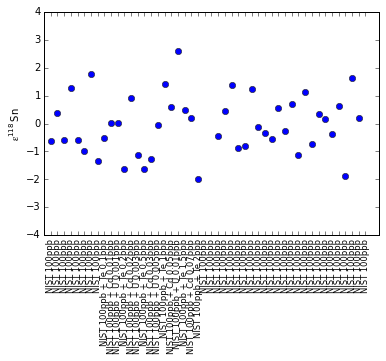

In [133]:
x = range(1, len(epsilon_comp["sample"])+1)
plot(x, epsilon_comp["112/120"], marker="o", ls="none")
ylim([-4, 4])
xticks(x, epsilon_comp["sample"], size='small', rotation=90)
ylabel(r'$\mathregular{\epsilon^{118}}$Sn')
#savefig(path+"epsilon_119.pdf", bbox_inches='tight')

In [7]:
df_all.to_csv(path_sav + "Sn_H8_L4_2_cycles_NU_Signals_zero_corr.csv", mode='a', header=False)

In [195]:
df_internal_sub.to_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm.csv", mode='a', header=False)

In [30]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_rel_to_118__122_118_no_bgd_corr.csv", mode='w', header=True)

In [1226]:
df_std.to_csv(path_sav + "All_standards_internal_norm_mean.csv")

In [986]:
df_all_mean_1 = pd.read_csv(path_sav + "Sn_H9_L4_1_cycles_internal_norm_mean.csv")

In [987]:
df_all_mean_2 = pd.read_csv(path_sav + "Sn_H8_L4_2_cycles_internal_norm_mean.csv")

In [1088]:
df_mean_all = df_all_mean_1.append(df_all_mean_2)

In [1089]:
df_mean_all = df_mean_all[2:]
df_mean_all.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
df_mean_all = df_mean_all[["Date", "112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118","sample"]]
df_mean_all = df_mean_all.set_index("Date") 

In [1182]:
df_std = df_mean_all[(df_mean_all["sample"] == "SPEX1 100ppb") | (df_mean_all["sample"] == "SPEX 100ppb") | (df_mean_all["sample"] == "NIST 100ppb")]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 20:49:00,0.0298238495726,0.0201845997439,0.0103681594438,0.446,0.235295696368,0.742939518097,0.263445942562,0.142086185109,0.177571556759,10.1619395381,SPEX1 100ppb
2014-10-07 21:07:00,0.0298270855009,0.0201887834143,0.0103664239291,0.446,0.235295260593,0.742937654621,0.263447680516,0.14208571056,0.177573088542,10.2834847296,SPEX1 100ppb
2014-10-07 21:29:00,0.0298241010738,0.0201850728708,0.0103667030734,0.446,0.235295046713,0.742937732217,0.263449417694,0.142085954225,0.17757007419,10.0068814188,SPEX1 100ppb
2014-10-07 21:46:00,0.0298269719657,0.0201827454973,0.0103676568054,0.446,0.235297077525,0.742936157145,0.263450048386,0.142089277895,0.177573191934,10.1732362802,SPEX1 100ppb
2014-11-18 18:22:00,0.0298319477344,0.0201968060654,0.0103609914838,0.446,0.235308007067,0.74295144542,0.263456437295,0.142073025422,0.17753393783,11.9205622223,NIST 100ppb
2014-11-18 18:27:00,0.0298302415426,0.0202014506204,0.0103609667001,0.446,0.235304600881,0.742949759778,0.263451222795,0.142074064497,0.177531032284,11.8435340427,NIST 100ppb
2014-11-18 18:31:00,0.029834566445,0.0202024281122,0.0103608586407,0.446,0.235309236679,0.742955467382,0.263452936054,0.142073215452,0.177533064574,11.3634385069,NIST 100ppb
2014-11-18 18:36:00,0.0298236482085,0.0201946006554,0.0103617565758,0.446,0.235308318118,0.742946848523,0.263449990275,0.142074569672,0.177530832831,11.5416992302,NIST 100ppb
2014-11-18 18:40:00,0.0298227478429,0.0201921659888,0.0103615705949,0.446,0.235307461611,0.742950591745,0.263450041891,0.142075223065,0.177536326791,11.6314409578,NIST 100ppb


In [1183]:
df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]] = df_std[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120", "118"]].astype(float)
df_std.index = df_std.index.astype(datetime64)
df_std = df_std[(df_std.index < pd.Timestamp('2015-03-10')) | (df_std.index > pd.Timestamp('2015-03-12'))]
df_std = df_std[(df_std.index < pd.Timestamp('2014-11-29 18:25:00')) | (df_std.index > pd.Timestamp('2014-11-29 20:27:00'))]
df_std

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-10-07 18:49:00,0.029824,0.020185,0.010368,0.446,0.235296,0.742940,0.263446,0.142086,0.177572,10.161940,SPEX1 100ppb
2014-10-07 19:07:00,0.029827,0.020189,0.010366,0.446,0.235295,0.742938,0.263448,0.142086,0.177573,10.283485,SPEX1 100ppb
2014-10-07 19:29:00,0.029824,0.020185,0.010367,0.446,0.235295,0.742938,0.263449,0.142086,0.177570,10.006881,SPEX1 100ppb
2014-10-07 19:46:00,0.029827,0.020183,0.010368,0.446,0.235297,0.742936,0.263450,0.142089,0.177573,10.173236,SPEX1 100ppb
2014-11-18 17:22:00,0.029832,0.020197,0.010361,0.446,0.235308,0.742951,0.263456,0.142073,0.177534,11.920562,NIST 100ppb
2014-11-18 17:27:00,0.029830,0.020201,0.010361,0.446,0.235305,0.742950,0.263451,0.142074,0.177531,11.843534,NIST 100ppb
2014-11-18 17:31:00,0.029835,0.020202,0.010361,0.446,0.235309,0.742955,0.263453,0.142073,0.177533,11.363439,NIST 100ppb
2014-11-18 17:36:00,0.029824,0.020195,0.010362,0.446,0.235308,0.742947,0.263450,0.142075,0.177531,11.541699,NIST 100ppb
2014-11-18 17:40:00,0.029823,0.020192,0.010362,0.446,0.235307,0.742951,0.263450,0.142075,0.177536,11.631441,NIST 100ppb


In [1184]:
df_std = df_std[(df_std["118"] > 5) & (df_std["118/120"] > 0.7428)]
for i in df_std.index[df_std["sample"] == "SPEX1 100ppb"]:
    df_std.ix[i, "sample"] = "SPEX 100ppb"

In [1220]:
sample = df_std["sample"]
std_mean = df_std[(df_std["sample"] == "SPEX 100ppb")].mean()
new = df_std[df_std.columns[df_std.dtypes != 'object']]
epsilon =  ((new / std_mean)-1)*10000
epsilon["sample"] = sample
epsilon
epsilon[(epsilon["118/120"] > 0.4) | (epsilon["118/120"] < -0.4)]

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,118,sample
Date,,,,,,,,,,,
2014-11-18 18:54:00,-1.295126,-1.053575,1.608025,1.998401e-11,-1.180555,-0.463371,-0.356364,0.722133,2.010156,1309.494419,SPEX 100ppb
2014-12-06 22:37:00,-4.936059,-7.445774,1.331682,1.998401e-11,0.786625,0.539985,1.003885,0.222717,0.767402,-1614.119882,SPEX 100ppb
2014-12-06 22:52:00,-1.620072,-3.896472,0.536870,1.998401e-11,0.533814,0.527568,1.004705,0.469725,1.664357,-1804.778746,SPEX 100ppb
2014-12-06 23:08:00,-2.641746,-4.386719,2.125820,1.998401e-11,0.522416,0.475452,0.892735,0.462190,1.555222,-1848.039153,SPEX 100ppb
2014-12-06 23:23:00,-3.243182,-3.908338,-0.299309,1.998401e-11,0.613841,0.489401,0.951723,0.466426,1.660720,-1728.263406,SPEX 100ppb
2014-12-06 23:39:00,-3.174104,-5.626922,2.187946,1.998401e-11,0.711496,0.500329,0.913301,0.302836,1.500547,-1512.382276,SPEX 100ppb
2014-12-06 23:54:00,-2.499252,-3.686348,3.196847,1.998401e-11,0.532245,0.565307,0.943385,0.268384,1.570411,-1442.654967,SPEX 100ppb
2014-12-07 00:09:00,-3.167063,-4.997893,0.608021,1.998401e-11,0.745353,0.520016,1.039127,0.455542,1.559710,-1523.698889,SPEX 100ppb
2014-12-07 00:25:00,-2.027759,-4.105014,2.820000,1.998401e-11,0.605650,0.507195,0.913818,0.470145,1.538801,-1719.373397,SPEX 100ppb


In [1222]:
lee = pd.DataFrame({"112/120" : pd.Series(0.029812), "114/120" : pd.Series(0.020195), "115/120": pd.Series(0.010366), "116/120": pd.Series(0.4460), "117/120" : pd.Series(0.235313), "118/120" : pd.Series(0.742935), "119/120" : pd.Series(0.263430), "122/120" : pd.Series(0.142086), "124/120" : pd.Series(0.177588)})
epsilon_lee = ((lee / std_mean[["112/120", "114/120", "115/120", "116/120", "117/120", "118/120", "119/120", "122/120", "124/120"]])-1)*10000
epsilon_lee["sample"] = "Lee et al. (1995)"
epsilon_lee

,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,sample
0,-4.252887,1.76055,-2.836398,1.998401e-11,0.6046,0.052729,-0.550984,0.411199,1.946529,Lee et al. (1995)
